In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show Code"></form>''')

# **Capstone Project 1: House price prediction**
## **Exploratory Data Analysis**



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set(style ='white',font_scale=1.25)

%matplotlib inline

## Load the dataset

In [2]:
housing = pd.read_csv('../data/01-House-Price/train.csv',index_col='Id')
housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Quick look as the datatype of features and target variable (*Sale Price*)

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

## Treating missing values
### Numercial features

In [4]:
housing_num = housing._get_numeric_data() # includes target label (Sale Price)

In [5]:
missing_vals_num = pd.DataFrame(columns=['Feature','# of missing values','% of missing values'])
for feature, numNan in housing_num.isnull().sum().iteritems():
    if numNan != 0 and housing_num[feature].dtypes!= 'object':
        missing_vals_num = pd.concat([missing_vals_num,
                                      pd.DataFrame([feature,numNan,(numNan/housing_num.shape[0])*100],
                                                                    index=['Feature','# of missing values',
                                                                           '% of missing values']).T])

missing_vals_num.reset_index(drop = True).sort_values(by='# of missing values',ascending=False)

,Feature,# of missing values,% of missing values
0,LotFrontage,259,17.7397
2,GarageYrBlt,81,5.54795
1,MasVnrArea,8,0.547945


'LotFrontage', 'GarageYrBlt', and 'MasVnrArea' are the only numerical features with missing values.

Lets check their distributions

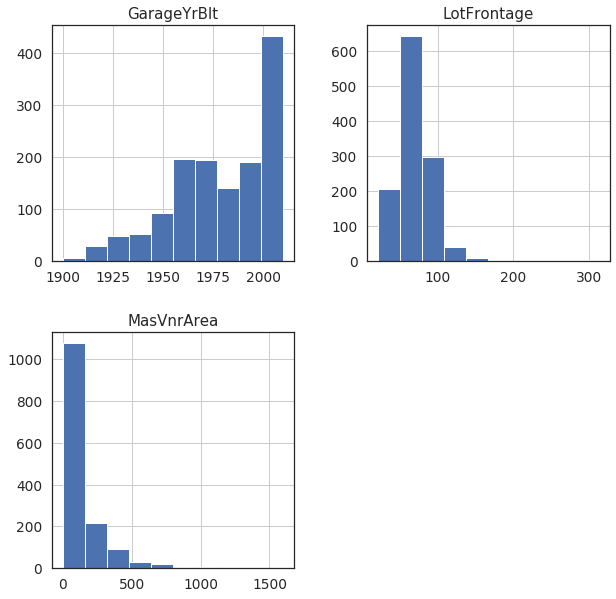

In [6]:
_=housing_num[['LotFrontage','GarageYrBlt','MasVnrArea']].hist(figsize=(10,10))

In [7]:
housing_num[['LotFrontage','GarageYrBlt','MasVnrArea']].median()

LotFrontage      69.0
GarageYrBlt    1980.0
MasVnrArea        0.0
dtype: float64

In this initial phase we can use median values, but ideally we would like to use advanced imputation methods such as those mentioned in https://towardsdatascience.com/handling-missing-values-in-machine-learning-part-2-222154b4b58e

Imputing the a median value of GrageYrBlt still does not make sense, will back to this later.

Following cell imputes medians as the missing values to *LotFrontage, GarageYrBlt, MasVnrArea*

try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy='median')
imputer.fit(housing_num)
housing_num = pd.DataFrame(imputer.transform(housing_num),
                              columns=housing_num.columns,
                              index=housing_num.index)

print('Imputed values')
print([np.round(num,decimals=1) for i, num in enumerate(imputer.statistics_) if housing_num.columns[i] in ['LotFrontage','GarageYrBlt','MasVnrArea']])

### Categorical features

In [8]:
housing_cat = housing.drop(labels=[col for col in housing_num.columns if 'SalePrice' not in col],axis=1) # Includes target label (SalePrice)

In [9]:
missing_vals_cat = pd.DataFrame(columns=['Feature', '# of missing vals','% of missing vals'])
for feature, numNan in housing_cat.isnull().sum().iteritems():
    if housing_cat[feature].dtypes == 'object' and numNan != 0:
        missing_vals_cat = pd.concat([missing_vals_cat,pd.DataFrame([feature,numNan,(numNan/housing_cat.shape[0])*100],
                                                          index=['Feature', '# of missing vals','% of missing vals']).T])
missing_vals_cat.sort_values(by=['% of missing vals'],ascending=False).reset_index(drop=True)

,Feature,# of missing vals,% of missing vals
0,PoolQC,1453,99.5205
1,MiscFeature,1406,96.3014
2,Alley,1369,93.7671
3,Fence,1179,80.7534
4,FireplaceQu,690,47.2603
5,GarageType,81,5.54795
6,GarageFinish,81,5.54795
7,GarageQual,81,5.54795
8,GarageCond,81,5.54795
9,BsmtExposure,38,2.60274



    PoolQC: NA = No Pool (ordinal)
    MiscFeature: NA = None (OneHot)
    Alley: NA = No alley access (OneHot)
    Fence: NA = No Fence (OneHot)
    FireplaceQu: NA = No fireplace (ordinal)
    GarageType: NA = No Garage (OneHot)
    GarageFinish: NA = No Garage (ordinal)
    GarageQual: NA = No Garage (ordinal)
    GarageCond: NA = No Garage (ordinal)
    BsmtFinType2: NA = No Basement (ordinal)
    BsmtQual: NA = No Basement (ordinal)
    BsmtCond: NA = No Basement (ordinal)
    BsmtFinType1: NA = No Basement (ordinal)
    MasVnrType: NA = None (OneHot)
    Electrical: NA = actually missing (no info available)
    
There are two categorical features, **Electrical** and **MasVnrArea**, that have missing values.
Both have insignificant amounts of missing values (0.07% and 0.55%), hence it will be reasonable to impute them with the most frequently occuring categories.

All other features have "meaningful" missing values. For example if a house does not have a basement, all features that give more information about basement are bound to be null values for that house.
Hence, replace the meaningful missing values in another category called **Missing**.

Text(0.5, 1.0, 'MasVnrType')

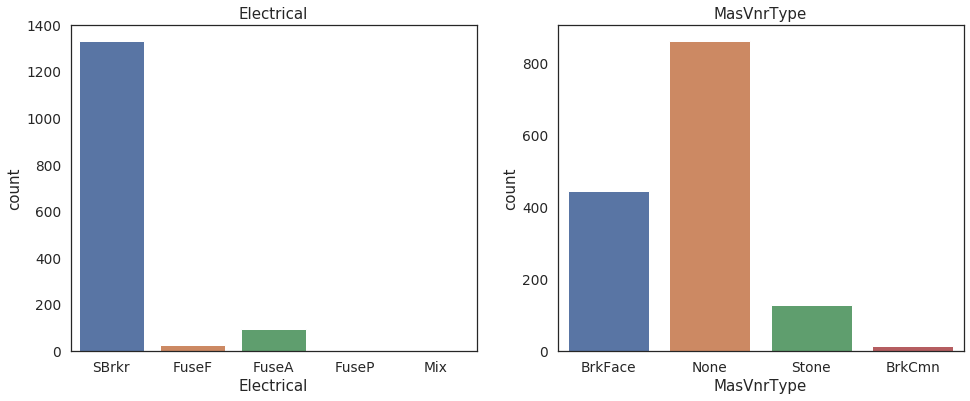

In [10]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(16,6))
sns.countplot(x='Electrical',data=housing_cat,ax=ax1)
ax1.set_title('Electrical')
sns.countplot(x='MasVnrType',data=housing_cat,ax=ax2)
ax2.set_title('MasVnrType')

**SBrkr** is the most frequent category in the **Electrical**.

**None** is the most frequent category in **MasVnrType**

Impute these categories in the missing rows of the respective features

Following function does the appropriate imputation:

In [11]:
def Impute(housing,attrib=['Electrical','MasVnrType']):
    tmp = housing.copy()
    for a in attrib:
        mode = tmp[a].mode()[0]
        tmp[a] = tmp[a].fillna(mode)
    tmp.fillna('Missing',inplace=True)
    return tmp

In [12]:
housing_cat = Impute(housing_cat)

Text(0.5, 1.0, 'MasVnrType')

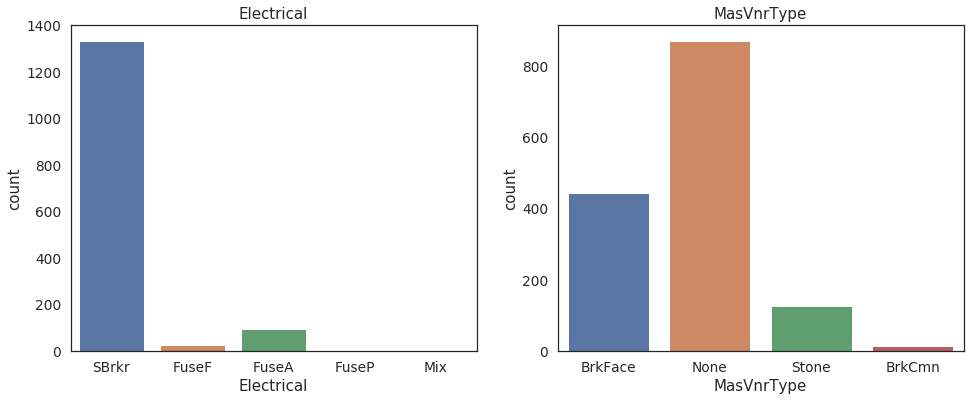

In [13]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(16,6))
sns.countplot(x='Electrical',data=housing_cat,ax=ax1)
ax1.set_title('Electrical')
sns.countplot(x='MasVnrType',data=housing_cat,ax=ax2)
ax2.set_title('MasVnrType')

### Number of unique categories per categorical feature

In [14]:
from collections import defaultdict

unique_cats = defaultdict(int)

for col in housing_cat.columns:
    if housing_cat[col].dtypes == 'object':
        unique_cats[col] = housing_cat[col].nunique()
        #print('{0}:\t\t {1} unique categories'.format(col,housing_cat[col].nunique()))

num_unique_cats = pd.Series(unique_cats)

## Data Visualization: Univariate

### Distribution of Sale Price

Text(0.5, 1.0, 'Sale Price')

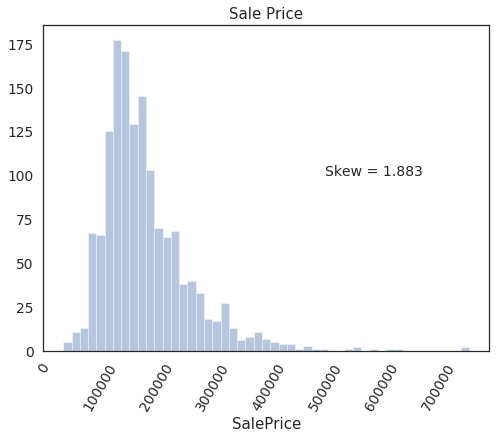

In [15]:
plt.figure(figsize = (8,6))
sns.distplot(housing_num['SalePrice'],kde=False)
plt.text(x=5e5, y=100,s='Skew = %.3f' %(housing_num.SalePrice.skew()),fontdict={'fontsize':14})

plt.xticks(rotation = 60)
plt.title('Sale Price')

The Sale price is not normally distribute and appears to be positively skewed.

Apply log transformation to Sale Price to make it more normally distributed.

In [16]:
for df in [housing_num, housing_cat,housing]:
    df['log1p(SalePrice)'] = np.log1p(df['SalePrice'])

Text(0.5, 1.0, 'log1p(Sale Price)')

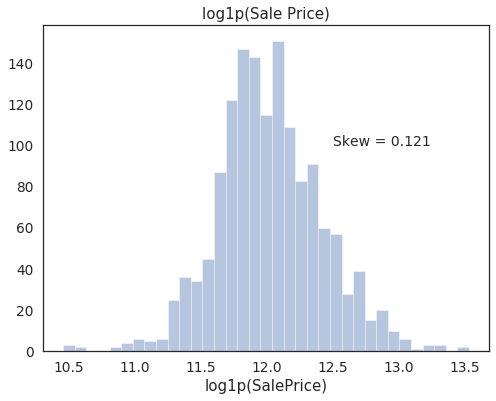

In [17]:
plt.figure(figsize = (8,6))
sns.distplot(housing_num['log1p(SalePrice)'],kde=False)
plt.text(x=12.5, y=100,s='Skew = %.3f' %(housing_num['log1p(SalePrice)'].skew()),fontdict={'fontsize':14})

plt.title('log1p(Sale Price)')

### Distribution of log1p(SalePrice) per category

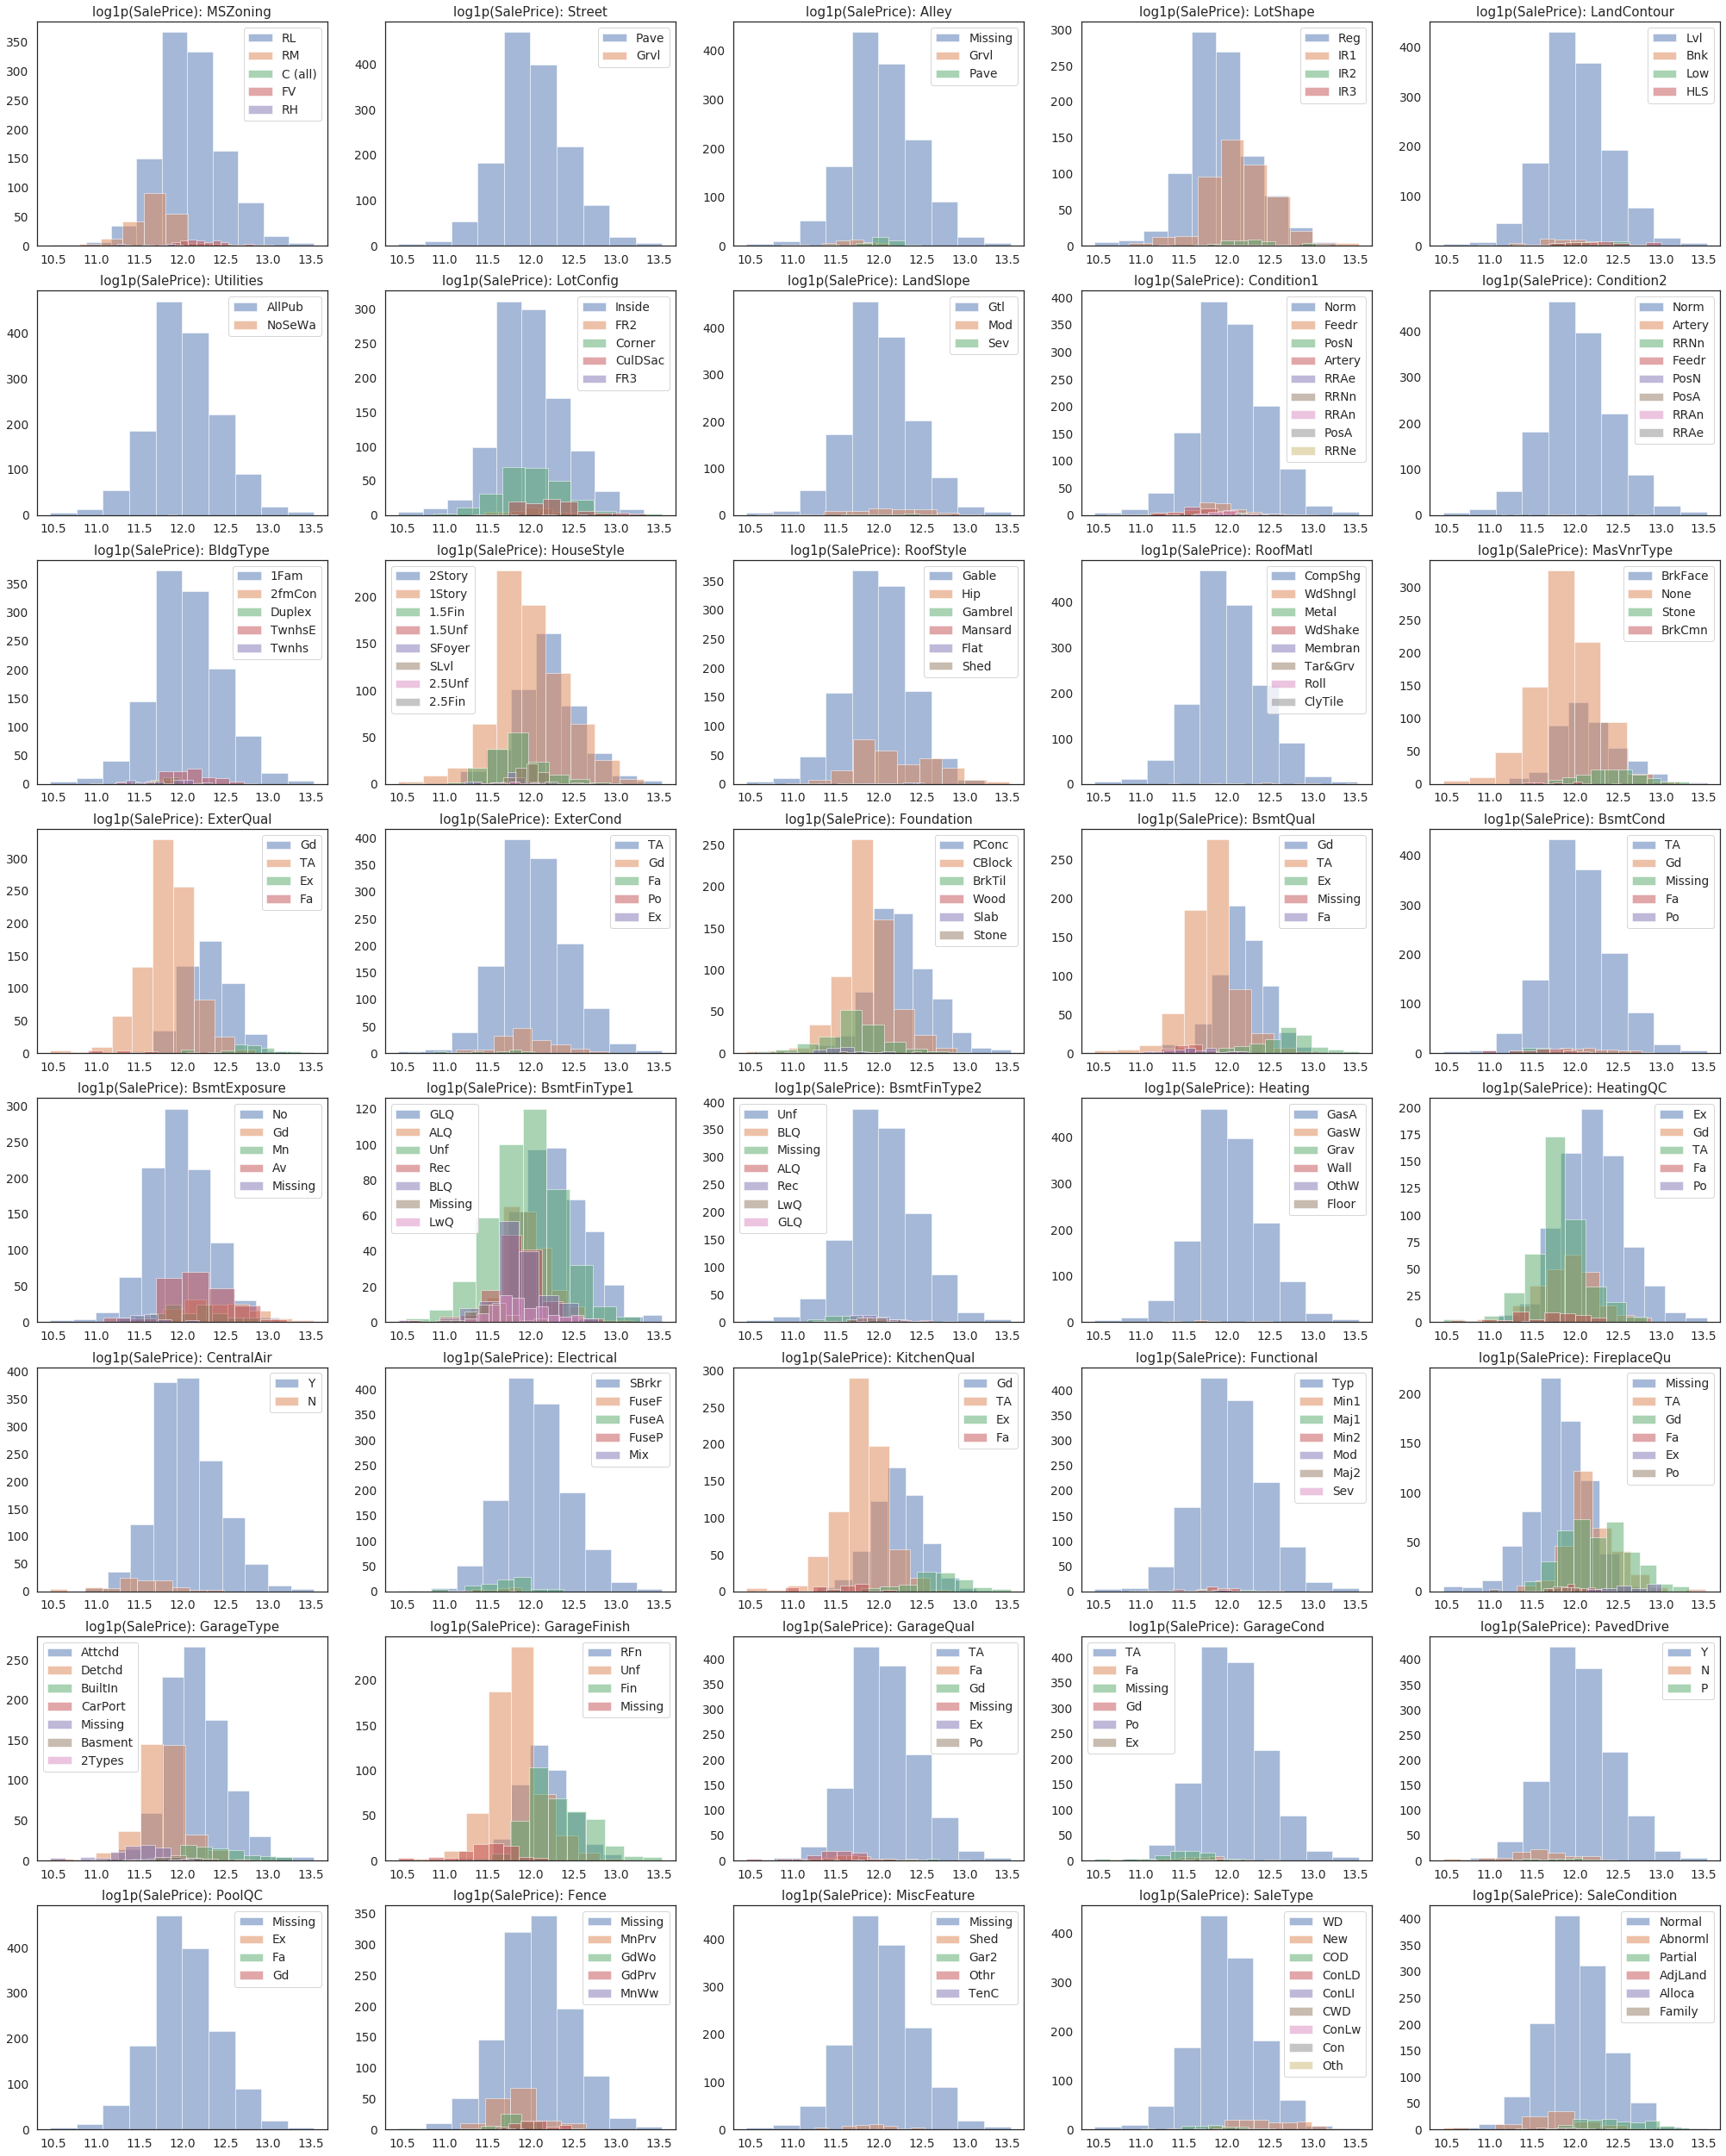

In [18]:
fig, axes = plt.subplots(nrows=8,ncols=5,figsize=(35,45))
axes = axes.flatten()

high_cat_features = defaultdict(int)
i = 0
for col in housing_cat.columns:
    if 'SalePrice' not in col:
        if len(housing_cat[col].unique()) > 10: # Plot only those cat features that have 10 categories or less for ease of viewing
            high_cat_features[col] = len(housing_cat[col].unique())
        else:
            for j, cat in enumerate(housing_cat[col].unique()):
                axes[i].hist(housing_cat['log1p(SalePrice)'][housing_cat[col] == cat],alpha=0.5, label = cat)

            axes[i].legend()
            axes[i].set_title('log1p(SalePrice): '+col)
            
            i+=1

Lets also plot distribution for the following three features that have more than 10 categories

In [19]:
print(high_cat_features)

defaultdict(<class 'int'>, {'Neighborhood': 25, 'Exterior1st': 15, 'Exterior2nd': 16})


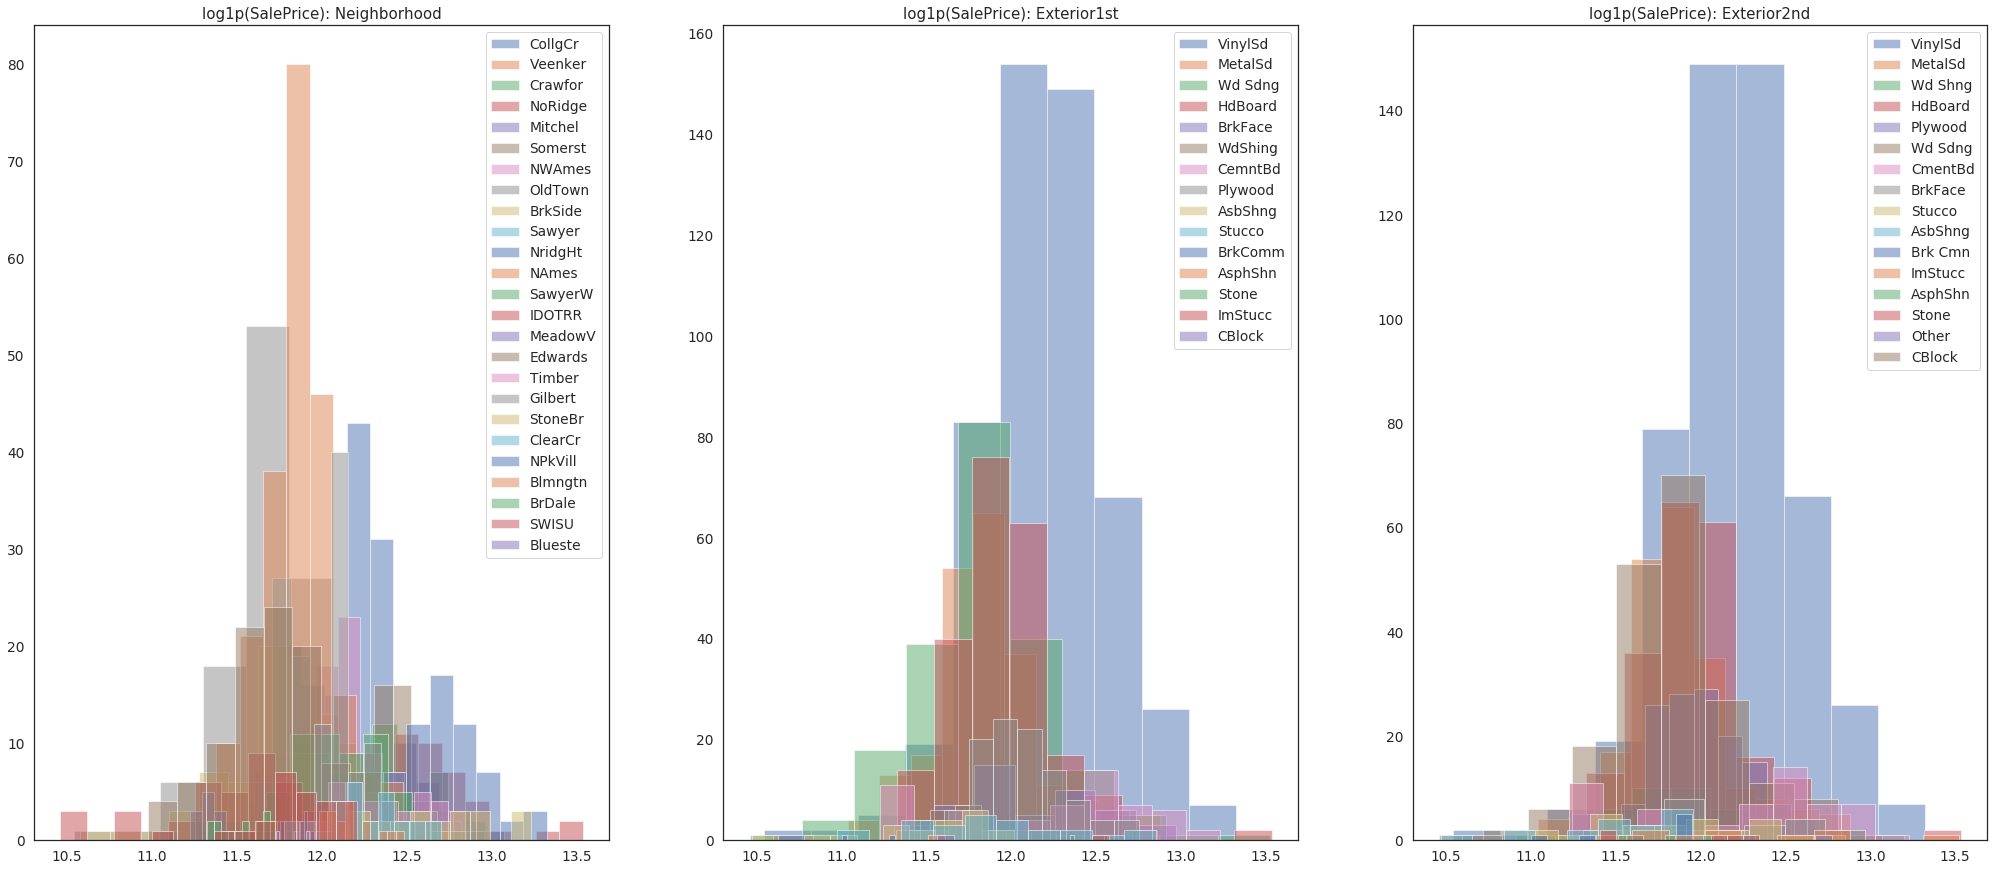

In [20]:
fig, axes = plt.subplots(ncols=3,figsize=(35,15))
axes = axes.flatten()

for i, col in enumerate(high_cat_features.keys()):
        for j, cat in enumerate(housing_cat[col].unique()):
            axes[i].hist(housing_cat['log1p(SalePrice)'][housing_cat[col] == cat],alpha=0.5, label = cat)

        axes[i].legend()
        axes[i].set_title('log1p(SalePrice): '+col)
            

**Observation**: In majority of the categorical features, there is signficanlty greater occurrence of one category than rest of the categories.

Lets define "significanlty greater occurrence" as at least more than combined occurrences of rest of the categories times the total number of categories in the feature minus one.

In [21]:
most_commom_cats = defaultdict()

for i, col in enumerate(num_unique_cats.index):
    most_freq = housing_cat[col].value_counts()[0]
    combined_rest = housing_cat[col].value_counts()[1:].sum()
    if most_freq > combined_rest*num_unique_cats[i]-1:
        most_commom_cats[col] = housing_cat[col].value_counts().index[0]
print(most_commom_cats)

defaultdict(None, {'Street': 'Pave', 'Alley': 'Missing', 'LandContour': 'Lvl', 'Utilities': 'AllPub', 'LandSlope': 'Gtl', 'Condition2': 'Norm', 'BldgType': '1Fam', 'RoofMatl': 'CompShg', 'ExterCond': 'TA', 'BsmtCond': 'TA', 'Heating': 'GasA', 'CentralAir': 'Y', 'Electrical': 'SBrkr', 'Functional': 'Typ', 'GarageQual': 'TA', 'GarageCond': 'TA', 'PavedDrive': 'Y', 'PoolQC': 'Missing', 'MiscFeature': 'Missing'})


In [22]:
def iscommon(row):
    common = []
    cols = list(most_commom_cats.keys())
    for i, col in enumerate(cols):
        if row[col] == most_commom_cats[col]:
            common.append(True)
        else:
            common.append(False)
            
    if sum(common)/len(cols) > 0.999:
        return 1
    else:
        return 0

0    823
1    637
Name: iscommon, dtype: int64


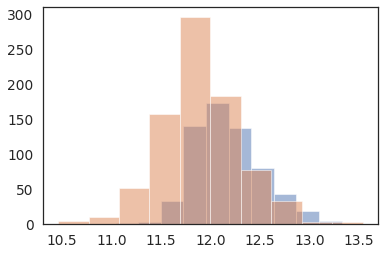

In [23]:
housing_cat['iscommon'] = housing_cat.apply(iscommon,axis=1)
print(housing_cat['iscommon'].value_counts())
_=plt.hist(housing_cat[housing_cat['iscommon']==1]['log1p(SalePrice)'],alpha=0.5,label='Common')
_=plt.hist(housing_cat[housing_cat['iscommon']==0]['log1p(SalePrice)'],alpha=0.5,label='Diverse')

**iscommon** column marks those houses which share same categorical levels for a set of categorical features.

### Testing if two ditributions have equal variances

In [24]:
from scipy.stats import levene, ttest_ind

similar = housing_cat[housing_cat['iscommon']==1]['log1p(SalePrice)'].values
diverse = housing_cat[housing_cat['iscommon']==0]['log1p(SalePrice)'].values

In [25]:
levene(similar,diverse)

LeveneResult(statistic=4.077288633511213, pvalue=0.04364604294774311)

**Inference**: There is strong evidence to suggest that the samples come from populations that have unequal variences

### Testing if the means of the two distributions are equal

In [26]:
ttest_ind(similar,diverse,equal_var=False)

Ttest_indResult(statistic=13.96775301276869, pvalue=1.1210705690856692e-41)

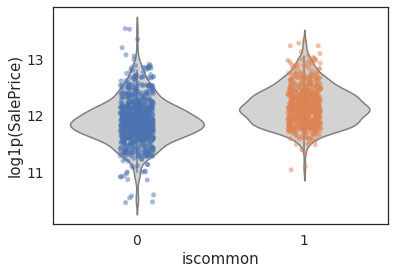

In [27]:
sns.violinplot(x='iscommon',y='log1p(SalePrice)',data=housing_cat,color='lightgray')
sns.stripplot(x='iscommon',y='log1p(SalePrice)',data=housing_cat,alpha=0.5)

**Inference**: Two distributions are significantly different. Having **iscommon** as the binary feature that distinguishes the two distributions may help in regression

#### One Hot Encode all the categorical features
    - housing_encoded_cat

In [28]:
housing_encoded_cat = pd.get_dummies(housing_cat.drop(labels=['SalePrice','log1p(SalePrice)'],
                                                     axis=1),
                                    drop_first=True)

In [29]:
print('Total number of cat features in housing_encoded_cat:', housing_encoded_cat.shape[1])

Total number of cat features in housing_encoded_cat: 224


We have simply OneHotEnoded all categorical features, this opens up a high possiblity of multicollinearity, so lets check VIFs housing_encoded_cat

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [31]:
housing_encoded_cat = sm.add_constant(housing_encoded_cat)
dict(zip(housing_encoded_cat.columns, [variance_inflation_factor(housing_encoded_cat.values,i) for i in range(housing_encoded_cat.shape[1])]))

/home/climbach/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/climbach/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


{'const': 13218.787618725533,
 'iscommon': 4.064066160351137,
 'MSZoning_FV': 16.84081570677998,
 'MSZoning_RH': 4.207130608938925,
 'MSZoning_RL': 47.519775650388205,
 'MSZoning_RM': 31.788696351776565,
 'Street_Pave': 1.5751150924572521,
 'Alley_Missing': 2.810740393979044,
 'Alley_Pave': 2.7169195637546872,
 'LotShape_IR2': 1.3218690767601327,
 'LotShape_IR3': 1.3955043260689828,
 'LotShape_Reg': 1.6653399690378659,
 'LandContour_HLS': 2.4145030669108594,
 'LandContour_Low': 2.583244220945349,
 'LandContour_Lvl': 3.553128574384026,
 'Utilities_NoSeWa': 1.2302153054511158,
 'LotConfig_CulDSac': 1.7079761957541826,
 'LotConfig_FR2': 1.3559501681132224,
 'LotConfig_FR3': 1.2037865597769233,
 'LotConfig_Inside': 1.7194010996325235,
 'LandSlope_Mod': 1.8649960987687613,
 'LandSlope_Sev': 2.164101420591379,
 'Neighborhood_Blueste': 1.414265590705824,
 'Neighborhood_BrDale': 3.4217430556298223,
 'Neighborhood_BrkSide': 8.572247599670767,
 'Neighborhood_ClearCr': 4.176689066088469,
 'Neighb

**Imp. Note**: As you can see there very high collinearity. We need to treat categorical features more carefully. We will come to this later and pick up from **housing_cat**. 

## Revisting missing value in numerical features

Earlier we found there were three numerical features (**LotFrontage, MasVnrArea, GarageYrBlt**) that had missing values and we imputed them with median values. Let explore some more informed way of imputing missing values.

- MasVnrArea: Since the most common category (None) was imputed in the **MasVnrType** feature, median MasVnrArea of houses that have "None" as the MasVnrType will be imputed.

In [32]:
MedianMasVnrArea = housing_num[housing_cat['MasVnrType'] == 'None']['MasVnrArea'].median()
housing_num['MasVnrArea'].fillna(MedianMasVnrArea,inplace=True)

- GarageYrBlt: these are same rows which have missing values in other garage related features, indicating that these houses do not have a garage. Imputing median value is a safe option.

In [33]:
housing_num['GarageYrBlt'].fillna(housing_num['GarageYrBlt'].median(),inplace=True)
print("Median GarageYrBlt: ",housing_num['GarageYrBlt'].median())

Median GarageYrBlt:  1980.0


In [34]:
missing_vals_num

,Feature,# of missing values,% of missing values
0,LotFrontage,259,17.7397
0,MasVnrArea,8,0.547945
0,GarageYrBlt,81,5.54795


- LotForntage: missing values needs to be handled more carefully as its 17.73% of the total oberservation

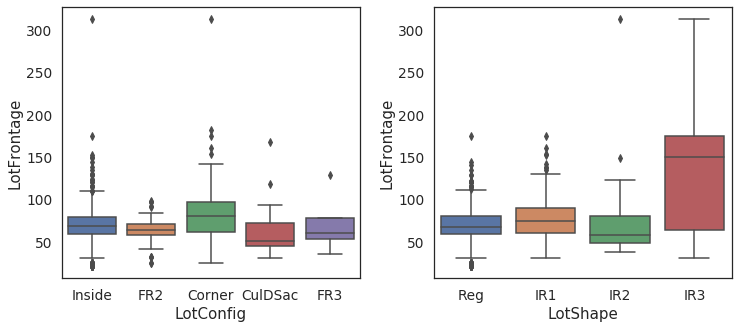

In [35]:
plt.figure(figsize = (12,5))
plt.subplots_adjust(wspace=0.25)
plt.subplot(1,2,1)
sns.boxplot(x='LotConfig',y='LotFrontage',data=housing)
plt.subplot(1,2,2)
sns.boxplot(x='LotShape',y='LotFrontage',data=housing)

In [36]:
housing.groupby(['LotConfig','LotShape'])['LotFrontage'].median().to_dict()

{('Corner', 'IR1'): 96.0,
 ('Corner', 'IR2'): 96.0,
 ('Corner', 'IR3'): 247.5,
 ('Corner', 'Reg'): 75.0,
 ('CulDSac', 'IR1'): 50.0,
 ('CulDSac', 'IR2'): 49.0,
 ('CulDSac', 'IR3'): 168.0,
 ('CulDSac', 'Reg'): nan,
 ('FR2', 'IR1'): 77.0,
 ('FR2', 'IR2'): 48.0,
 ('FR2', 'Reg'): 64.5,
 ('FR3', 'IR1'): 60.0,
 ('FR3', 'Reg'): 59.0,
 ('Inside', 'IR1'): 71.0,
 ('Inside', 'IR2'): 71.0,
 ('Inside', 'IR3'): 63.0,
 ('Inside', 'Reg'): 65.0}

In [37]:
def imputeLotFrontage(housing,housing_num):
    LotFrontageImuter = housing.groupby(['LotConfig','LotShape'])['LotFrontage'].median().to_dict()
    for key,val in LotFrontageImuter.items():
        LotConfig,LotShape = key
        housing_num.loc[(housing['LotFrontage'].isnull()) & (housing['LotConfig']==LotConfig) & (housing['LotShape']==LotShape),['LotFrontage']] = val
        
    housing_num.loc[housing_num['LotFrontage'].isnull(),'LotFrontage'] = housing_num['LotFrontage'].median()
    return housing_num

In [38]:
housing_num = imputeLotFrontage(housing,housing_num)

In [39]:
housing_num.isnull().sum()

MSSubClass          0
LotFrontage         0
LotArea             0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea          0
BsmtFinSF1          0
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        0
BsmtHalfBath        0
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
TotRmsAbvGrd        0
Fireplaces          0
GarageYrBlt         0
GarageCars          0
GarageArea          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SalePrice           0
log1p(SalePrice)    0
dtype: int64